<a id="start"></a>
# Прогнозирование оттока клиентов в фитнес центре


### Цель исследования:
1. Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
2. Сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства
3. Проанализировать основные признаки, наиболее сильно влияющие на отток клиентов
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов
    * предложить меры по снижению оттока
    * определить другие особенности взаимодействия с клиентами


### Содержание

* [Загрузка данных](#part1)
* [Анализ данных](#part2)
    * [Изучаем стандартные отклонения и средние значения](#part2-1)
    * [Гистограмммы распределения признаков](#part2-2)
    * [Матрица корреляции](#part2-3)
* [Модель прогнозирования оттока клиентов](#part3)
    * [Обучение моделей](#part3-1)
    * [Анализ результатов работы моделей](#part3-2)
* [Кластеризация клиентов](#part4)
    * [Расчет средних значений кластров](#part4-1)
    * [Распределение признаков для кластеров](#part4-2)
    * [Доля оттока по кластерам](#part4-3)
* [Выводы и рекомендации](#part5)

<a id="part1"></a>
## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mth
import datetime as dt
from scipy import stats as st
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import style

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv', sep=',')

In [3]:
#предварительный анализ
display(data.head(10))
data.info()
data.columns = data.columns.str.replace('gender', 'Gender') #Привожу названия столбцов к одному виду

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Отличное качество данных датасета - явных пропусков и дубликатов нет! Всё, что понадобилось сделать, это привести название одного из столбцов к общему виду.

<a id="part2"></a>
## Анализ данных

<a id="part2-1"></a>
### Изучаем стандартные отклонения и средние значения. Проверяем есть ли пропуски в датасете.

In [4]:
display(data.describe())
print(data.duplicated().sum())
print(data.isnull().sum().sum())

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


0
0


<a id="part2-2"></a>
### Проверяем средние значения признаков в двух группах: те, кто ушел и те, кто нет.

In [5]:
data.groupby('Churn').mean().reset_index().T

,0,1
Churn,0.000000,1.000000
Gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899


* Сотрудники компаний-партнеров реже бросают занятия.
* Те, кого привели друзья тоже реже бросают занятия.
* Попадающие в отток клиенты, как правило, покупают абонементы на более долгие сроки.
* Надежные клиенты посещяют групповые занятия в 2 раза чаще и чаще пользуются прочими услугами фитнес-центра
* Ненадежные клиенты немного моложе надежных, бросают занятия чере месяц, при том что у них на абонементе остается еще полтора месяца, на 25 процентов реже посещают зал в неделю, и в 2 раза реже в месяц.

<a id="part2-3"></a>
### Гистограмммы распределения признаков

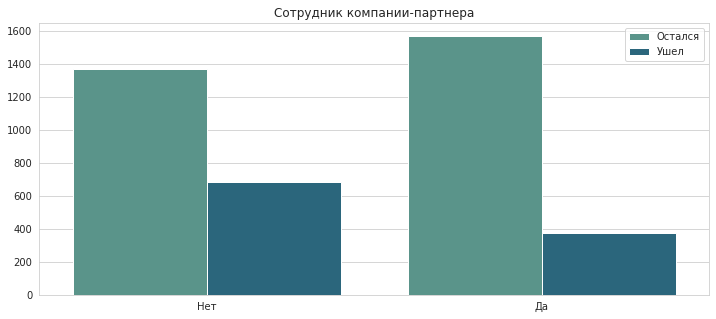

In [6]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'Partner', hue = 'Churn', data = data, palette='crest').set(xticklabels=["Нет", "Да"])
plt.ylabel('')
plt.xlabel('')
plt.legend(['Остался','Ушел'])
plt.title('Сотрудник компании-партнера')

plt.show();

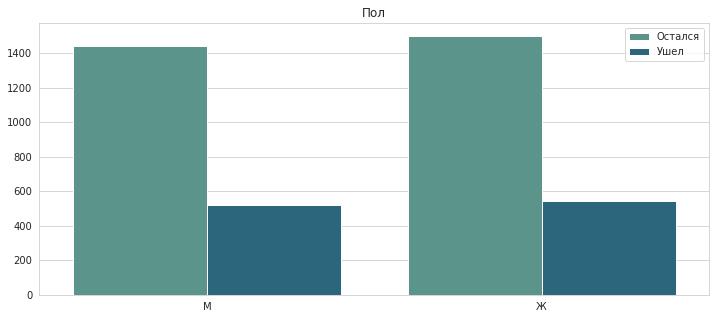

In [7]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'Gender', hue = 'Churn', data = data, palette='crest').set(xticklabels=["М", "Ж"])
plt.legend(['Остался','Ушел'])
plt.title('Пол')
plt.ylabel('')
plt.xlabel('')
plt.show();

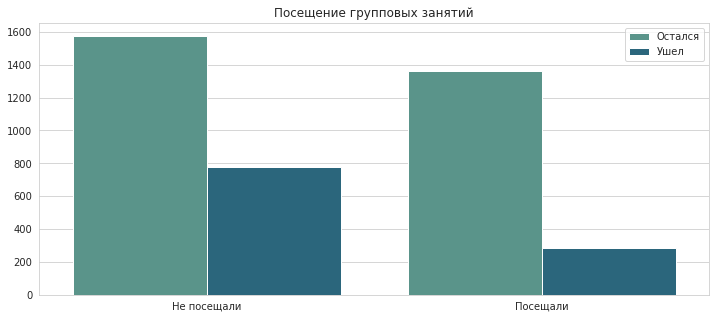

In [8]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'Group_visits', hue = 'Churn', data = data, palette='crest').set(xticklabels=["Не посещали", "Посещали"])
plt.legend(['Остался','Ушел'])
plt.title('Посещение групповых занятий')
plt.ylabel('')
plt.xlabel('')
plt.show();

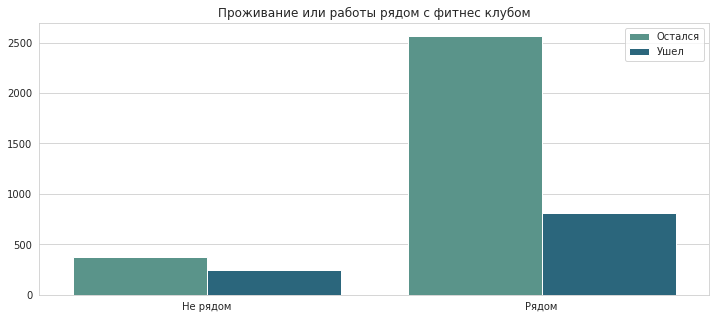

In [9]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'Near_Location', hue = 'Churn', data = data, palette='crest').set(xticklabels=["Не рядом", "Рядом"])
plt.legend(['Остался','Ушел'])
plt.title('Проживание или работы рядом с фитнес клубом')
plt.ylabel('')
plt.xlabel('')
plt.show();

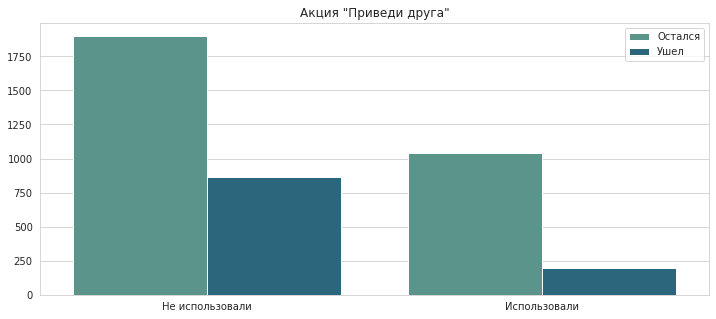

In [10]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'Promo_friends', hue = 'Churn', data = data, palette='crest').set(xticklabels=["Не использовали", "Использовали"])
plt.legend(['Остался','Ушел'])
plt.legend(['Остался','Ушел'])
plt.title('Акция "Приведи друга"')
plt.ylabel('')
plt.xlabel('')
plt.show();

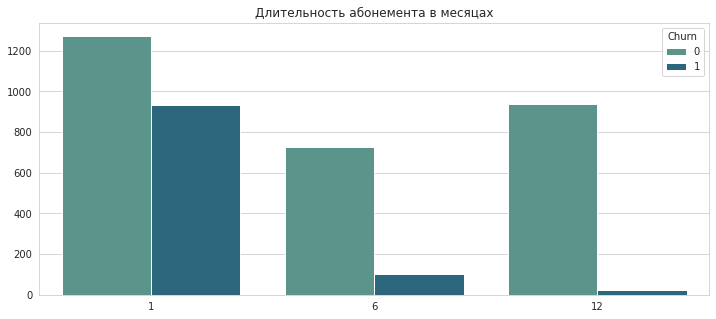

In [11]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'Contract_period', hue = 'Churn', data = data, palette='crest')
plt.title('Длительность абонемента в месяцах')
plt.ylabel('')
plt.xlabel('')
plt.show();

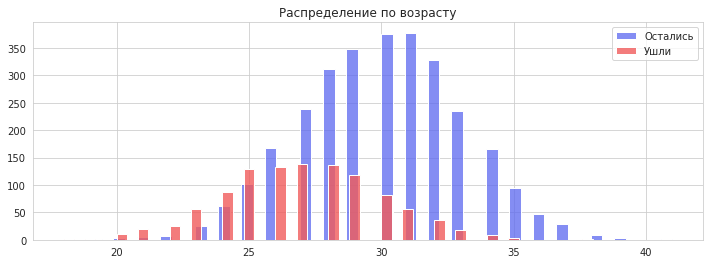

In [12]:
fig, ax = plt.subplots(figsize = (12, 4))
    
sns.histplot(data[data['Churn']==0]['Age'], bins = 50, label = 'Остались', color = '#5b67f0')
sns.histplot(data[data['Churn']==1]['Age'], bins = 50, label = 'Ушли', color = '#f05b5b', alpha=.8)
plt.xlabel('')
plt.ylabel('')
plt.legend()
    
#sns.boxplot(y = 'Age', x = 'Сhurn', data = data, ax = plt.subplot(1, 2, 2), palette='Pastel2_r').set(xticklabels=["Нет", "Да"])
#plt.xlabel('')
#plt.ylabel('')
#plt.xticks(np.arange(2), ('Действующие клиенты', 'Отток'))
    
#fig.suptitle(title + ' (' + col + ')')
plt.title('Распределение по возрасту')
plt.show();

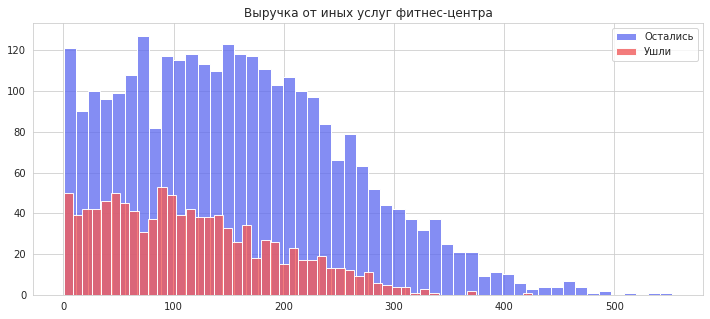

In [13]:
plt.figure(figsize=(12, 5))
    
sns.histplot(data[data['Churn']==0]['Avg_additional_charges_total'], bins = 50, label = 'Остались', color = '#5b67f0')
sns.histplot(data[data['Churn']==1]['Avg_additional_charges_total'], bins = 50, label = 'Ушли', color = '#f05b5b', alpha=.8)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.title('Выручка от иных услуг фитнес-центра')
plt.show();

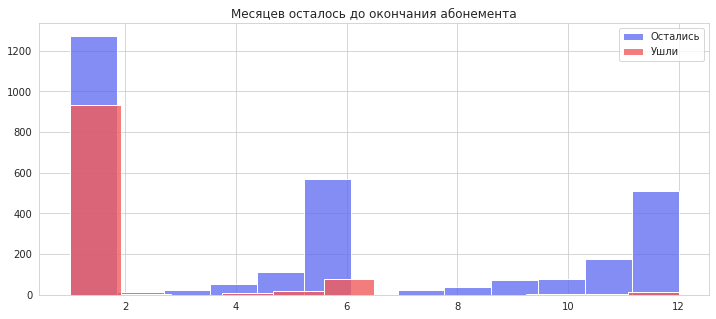

In [14]:
plt.figure(figsize=(12, 5))
    
sns.histplot(data[data['Churn']==0]['Month_to_end_contract'], label = 'Остались', color = '#5b67f0')
sns.histplot(data[data['Churn']==1]['Month_to_end_contract'], label = 'Ушли', color = '#f05b5b', alpha=.8)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.title('Месяцев осталось до окончания абонемента')
plt.show();

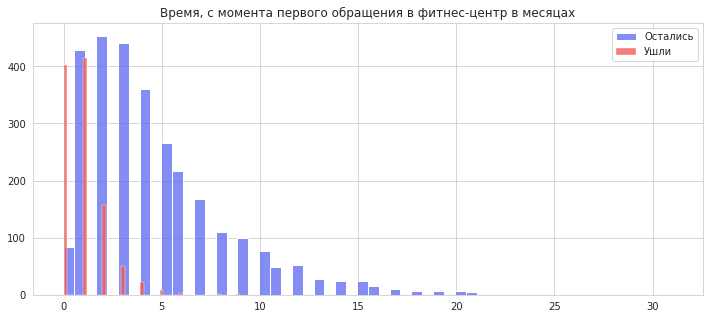

In [15]:
plt.figure(figsize=(12, 5))
    
sns.histplot(data[data['Churn']==0]['Lifetime'], label = 'Остались', color = '#5b67f0')
sns.histplot(data[data['Churn']==1]['Lifetime'], label = 'Ушли', color = '#f05b5b', alpha=.8)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.title('Время, с момента первого обращения в фитнес-центр в месяцах')
plt.show();

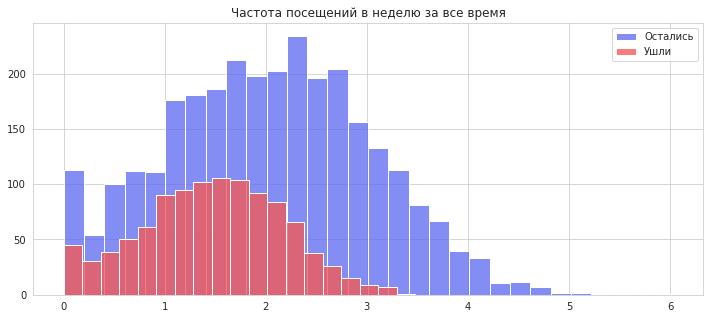

In [16]:
plt.figure(figsize=(12, 5))
    
sns.histplot(data[data['Churn']==0]['Avg_class_frequency_total'], label = 'Остались', color = '#5b67f0')
sns.histplot(data[data['Churn']==1]['Avg_class_frequency_total'], label = 'Ушли', color = '#f05b5b', alpha=.8)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.title('Частота посещений в неделю за все время')
plt.show();

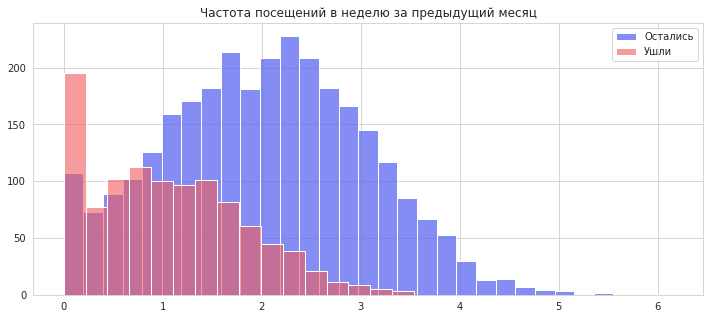

In [17]:
plt.figure(figsize=(12, 5))
    
sns.histplot(data[data['Churn']==0]['Avg_class_frequency_current_month'], label = 'Остались', color = '#5b67f0')
sns.histplot(data[data['Churn']==1]['Avg_class_frequency_current_month'], label = 'Ушли', color = '#f05b5b', alpha=.6)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.title('Частота посещений в неделю за предыдущий месяц')
plt.show();

<b>Выводы:</b>

- Сотрудники компании-партнера примерно в два раза надежнее.
- Пол не влияет на отток.
- Посещающие групповые занятия клиенты попадают в отток намного реже, как и живущие или работающие рядом.
- Акция "приведи друга" привлекает много надежных клиентов.
- Чуть менее половины клиентов, приобретающих абонемент на месяц, попадают в отток. Вероятно, люди покупают абонемент чтобы попробовать и если фитнес-центр нравится, покупают уже более длительный абонемент. График оставшихся месяцев повторяет эту информацию.
- Ушедшие, в среднем, примерно на 5 лет моложе остальных.
- Выручка от иных услуг никак не связанна с оттоком.
- Большинство ушедших клтентов "отваливается" в первые три месяца с момента первого посещения фитнес-центра.
- Ушедшие, по большей части, посещают фитнес-центр от одного до двух раз в неделю+ а ушедшие от одного до трех, но разница не сильно выраженная.
- Перед тем как попасть в отток частота посещений у клиента падает. Это логично.

<a id="part2-4"></a>
###  Матрица корреляции

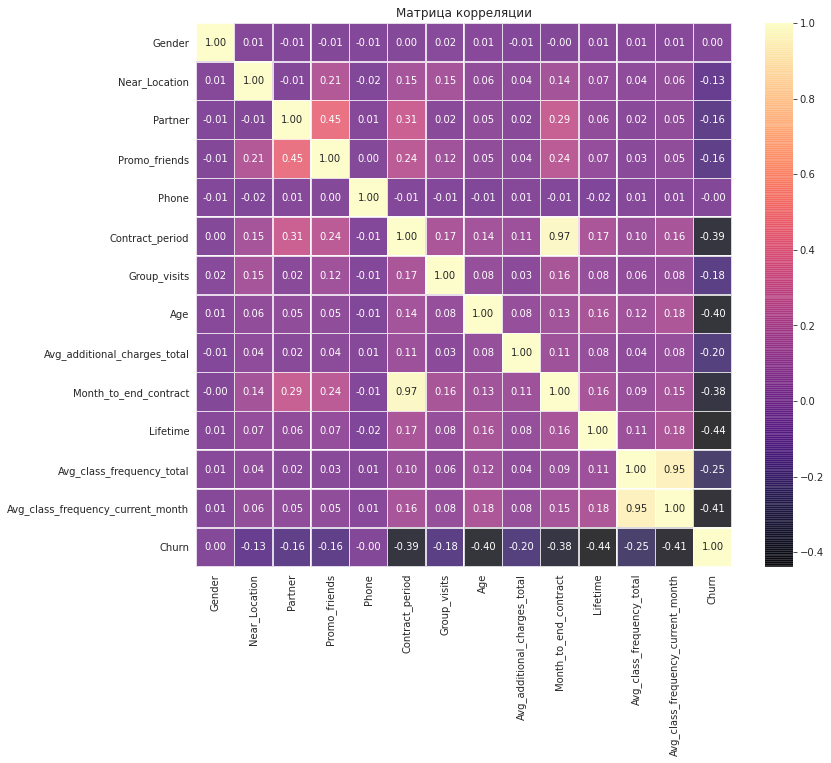

In [18]:
plt.figure(figsize=(12, 10))

sns.heatmap(data.corr(), annot=True, linewidths=.5, cmap='magma',fmt = '0.2f', alpha=.8)

plt.title('Матрица корреляции')
plt.show();

Тепловая карта подтверждает выводы в пункте 2.3.

Наибольшая корреляция с вероятностью оттока у времени с момента первого посещения. Чем больше времени прошло, тем меньше вероятность что клиент уйдет.

Обратная корреляция наблюдается у частоты посещения за последний месяц, сроке действующего абонемента, возраста и количества месяцев до конца абонемента.

Пол и телефон соверщенно ника не коррелируют.

Несколько признаков сильно коррелируют между собой из-за одномесячных абонементов (например срок абонемента и месяцы до истечения абонемента). А из интересного - высокая корреляция у сотрудников компаний-партнеров и пришедших по акции "приведи друга".

<a id="part3"></a>
## Модель прогнозирования оттока клиентов

<a id="part3-1"></a>
### Обучение моделей

Теперь построю две модели для прогнозирования - логистическую регресссию и случайный лес и обучу их.

In [19]:
# Логистическая регрессия

# задаю алгоритм для модели
m_logreg = LogisticRegression(solver='liblinear')

# разделяю наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('Churn', axis = 1)
y = data['Churn']

# разделяю модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

# обучаю модель
m_logreg.fit(X_train, y_train)

# использую обученную модель для получения прогноза на валидационной выборке
lr_predictions = m_logreg.predict(X_test)

display('Модель логистической регрессии обучена!')

'Модель логистической регрессии обучена!'

In [20]:
#Случайный лес

# обучаю StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразую обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# задаю алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучаю модель алгоритмом Случайный Лес - Random Forest
rf_model.fit(X_train_st, y_train)

# использую обученную модель для получения прогноза на валидационной выборке
rf_predictions = rf_model.predict(X_test_st)

display('Модель случайного леса обучена!')

'Модель случайного леса обучена!'

<a id="part3-2"></a>
### Анализ результатов работы моделей

In [21]:
#анализ метрик

print('Модель логистической регрессии:')
print('\tAccuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('\tPrecision (Точность): {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('\tRecall (Полнота): {:.2f}'.format(recall_score(y_test, lr_predictions)))

print('Модель случайного леса:')
print('\tAccuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('\tPrecision (Точность): {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('\tRecall (Полнота): {:.2f}'.format(recall_score(y_test, rf_predictions)))

Модель логистической регрессии:
	Accuracy (Доля правильных ответов): 0.93
	Precision (Точность): 0.89
	Recall (Полнота): 0.84
Модель случайного леса:
	Accuracy (Доля правильных ответов): 0.92
	Precision (Точность): 0.88
	Recall (Полнота): 0.83


<b>Вывод:</b>
Модель логистической регресси показала себя немного лучше по всем метрикам

<a id="part4"></a>
## Кластеризация клиентов

<a id="part4-1"></a>
### Расчет средних значений кластеров

Проведем кластеризацию клиентов для выявления наиболее склонных к оттоку. Для этого построю матрицу расстояний с помощью функции linkage()

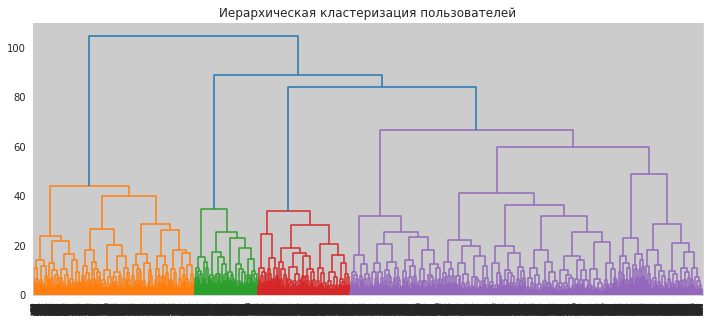

In [22]:
# Удаляю столбец с оттоком
data_nochurn = data.drop('Churn', axis = 1)

# Стандартизирую данные
sc = StandardScaler()
data_nochurn_sc = sc.fit_transform(data_nochurn)

# Строю матрицу расстояний
linked = linkage(data_nochurn_sc, method = 'ward')

# Строю дендраграмму
plt.style.use('fast')
plt.figure(figsize=(12, 5))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей')
plt.show()

На дендрограме 4 цвета, но один из них больше остальных, его можно разделить на два.

In [23]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0) 

# прогнозирую кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(data_nochurn_sc)

# сохраняю метки кластера в поле нашего датасета
data['cluster_km'] = labels

# вывожу статистику по средним значениям наших признаков по кластеру
display(data.groupby('cluster_km').mean().T)

cluster_km,0,1,2,3,4
Gender,0.502970,0.522078,0.495050,0.485737,0.559666
Near_Location,0.959406,0.862338,0.000000,1.000000,0.976134
Partner,0.783168,0.470130,0.463366,0.350238,0.356802
Promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
Phone,1.000000,0.000000,1.000000,1.000000,0.998807
Contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
Group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
Age,29.982178,29.301299,28.477228,28.167987,30.125298
Avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
Month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Кластеры разделились на три группы:

- Кластер 0 и 4 - самые надежные по параметру оттока, они посещают фитнес-центр чаще остальных, давно пользуются услугами, у них похожий возраст, они одинакого используют доп услуги но отличаются между собой длительностью абонемента и количеством пользователей партнёрской программы и акции "приведи друга".
- Кластер 1 - середнячки, 25% попали в отток но по всем параметрам они находятся посередине и особо ничем не выделяются.
- Кластеры 2 и 3 - Наиболее склонные к оттоку, этот показатель в районе 50%. Посещают реже остальных, пользуются услугами недавно, длительность абонемента как полная так и оставшееся меньше чем у других групп, редко посещают групповые занятия, возраст незначительно меньше, меньше других тратят на доп услуги.



<a id="part4-2"></a>
### Распределение признаков для кластеров

Построим графики распределения признаков для каждого кластера:

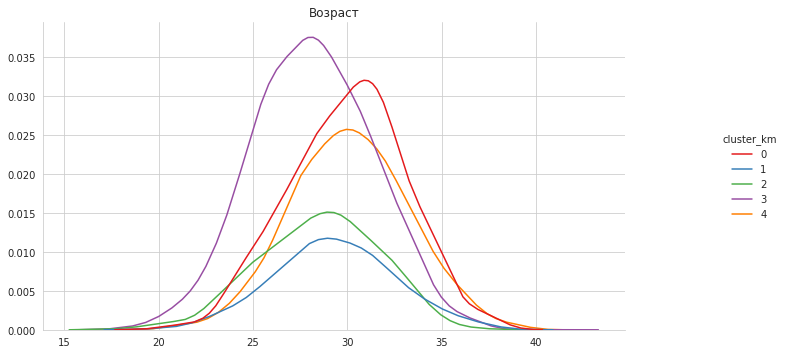

In [24]:
#Возраст
g = sns.displot(data = data, x =  data['Age'], hue = data['cluster_km'], kind = 'kde', palette = 'Set1')
g.fig.set_size_inches(12,5)
plt.xlabel('')
plt.ylabel('')
#plt.legend()
plt.title('Возраст')
#plt.figure(figsize=(12, 5))
plt.show();

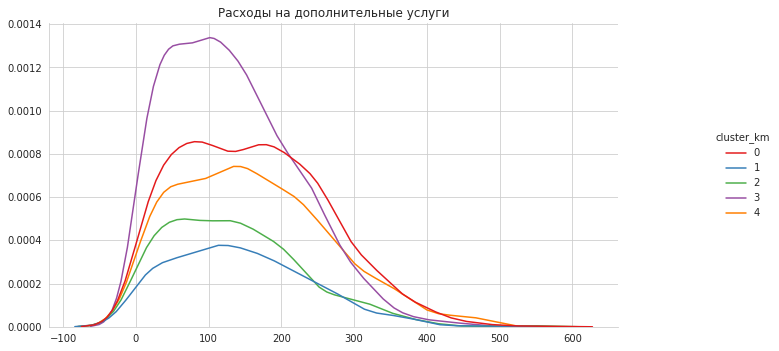

In [25]:
#Траты на доп услуги
g = sns.displot(data = data, x =  data['Avg_additional_charges_total'], hue = data['cluster_km'], kind = 'kde', palette = 'Set1')
g.fig.set_size_inches(12,5)
plt.xlabel('')
plt.ylabel('')
plt.title('Расходы на дополнительные услуги')
plt.show();

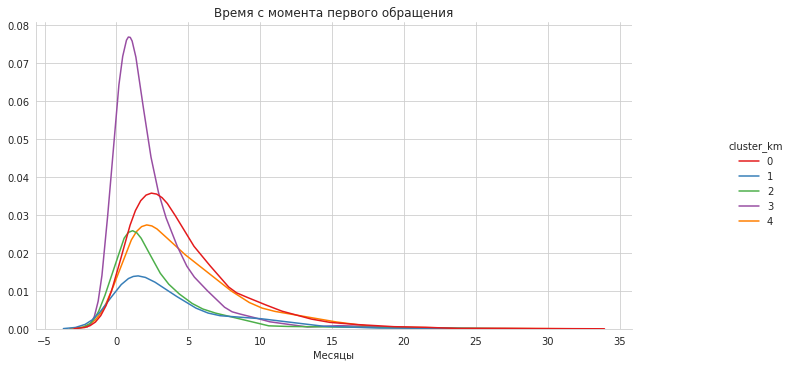

In [26]:
#Время с первого обращения
g = sns.displot(data = data, x =  data['Lifetime'], hue = data['cluster_km'], kind = 'kde', palette = 'Set1')
g.fig.set_size_inches(12,5)
plt.xlabel('Месяцы')
plt.ylabel('')
plt.title('Время с момента первого обращения')
plt.show();

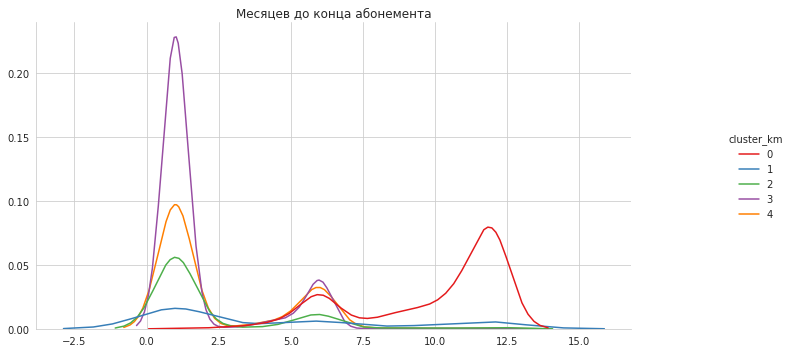

In [27]:
#Оставшиеся месяцы до окончания абонемента
g = sns.displot(data = data, x =  data['Month_to_end_contract'], hue = data['cluster_km'], kind = 'kde', palette = 'Set1')
g.fig.set_size_inches(12,5)
plt.xlabel('')
plt.ylabel('')
plt.title('Месяцев до конца абонемента')
plt.show();

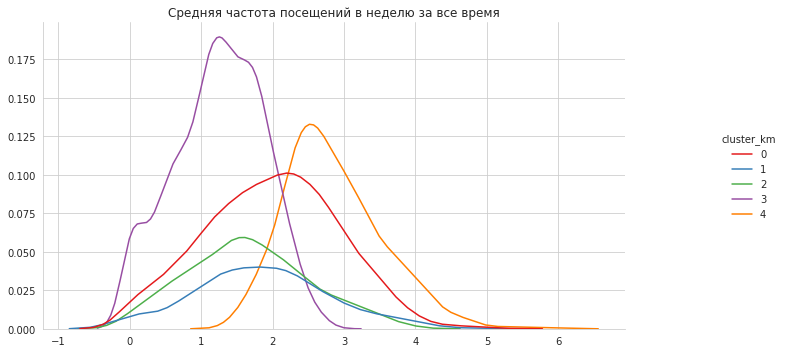

In [28]:
#Частота посещений за все время
g = sns.displot(data = data, x =  data['Avg_class_frequency_total'], hue = data['cluster_km'], kind = 'kde', palette = 'Set1')
g.fig.set_size_inches(12,5)
plt.xlabel('')
plt.ylabel('')
plt.title('Средняя частота посещений в неделю за все время')
plt.show();

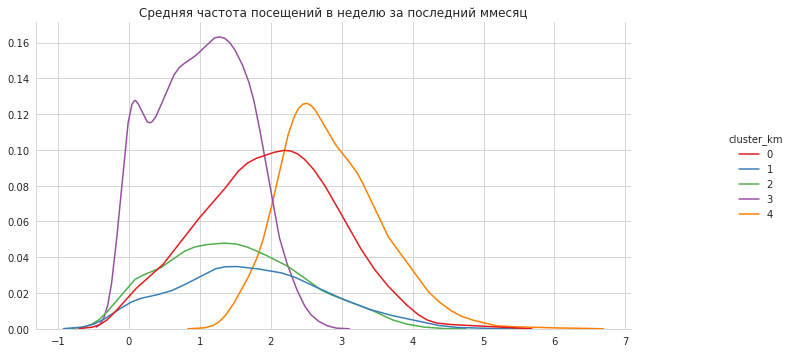

In [29]:
#Частота посещений за все время
g = sns.displot(data = data, x =  data['Avg_class_frequency_current_month'], hue = data['cluster_km'], kind = 'kde', palette = 'Set1')
g.fig.set_size_inches(12,5)
plt.xlabel('')
plt.ylabel('')
plt.title('Средняя частота посещений в неделю за последний ммесяц')
plt.show();

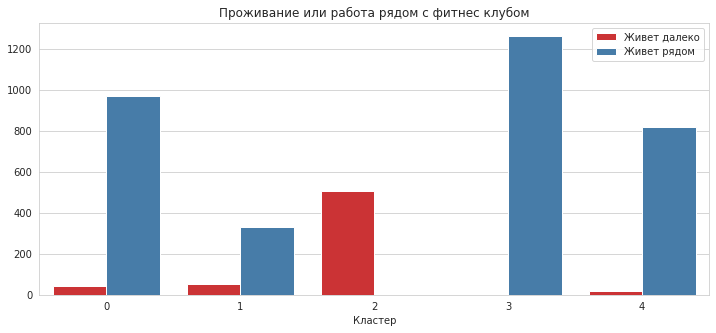

In [30]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'cluster_km', hue = 'Near_Location', data = data, palette='Set1')
plt.legend(['Живет далеко','Живет рядом'])
plt.title('Проживание или работа рядом с фитнес клубом')
plt.ylabel('')
plt.xlabel('Кластер')
plt.show();

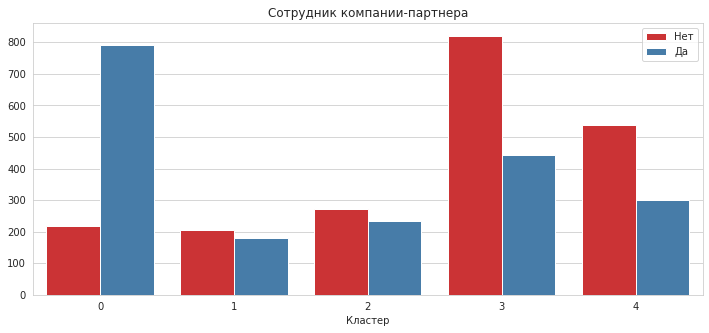

In [31]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'cluster_km', hue = 'Partner', data = data, palette='Set1')
plt.legend(['Нет','Да'])
plt.title('Сотрудник компании-партнера')
plt.ylabel('')
plt.xlabel('Кластер')
plt.show();

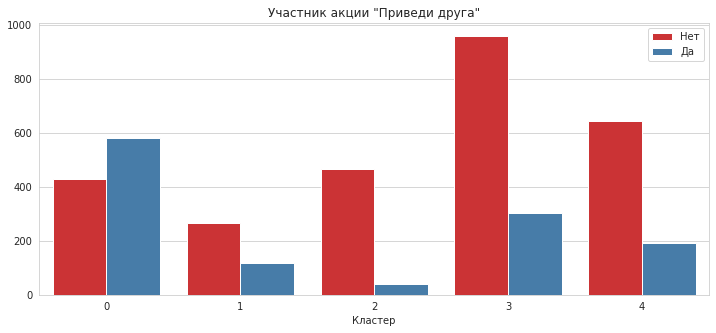

In [32]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'cluster_km', hue = 'Promo_friends', data = data, palette='Set1')
plt.legend(['Нет','Да'])
plt.title('Участник акции "Приведи друга"')
plt.ylabel('')
plt.xlabel('Кластер')
plt.show();

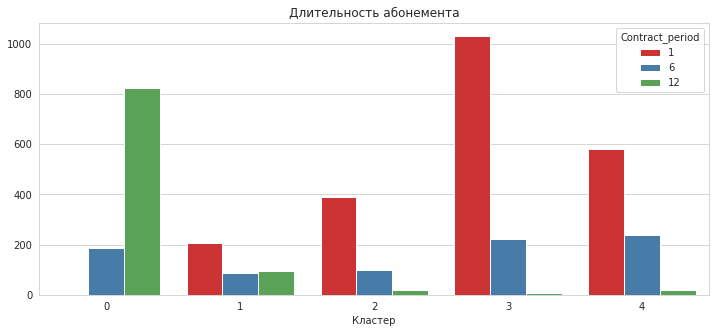

In [33]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'cluster_km', hue = 'Contract_period', data = data, palette='Set1')
plt.title('Длительность абонемента')
plt.ylabel('')
plt.xlabel('Кластер')
plt.show();

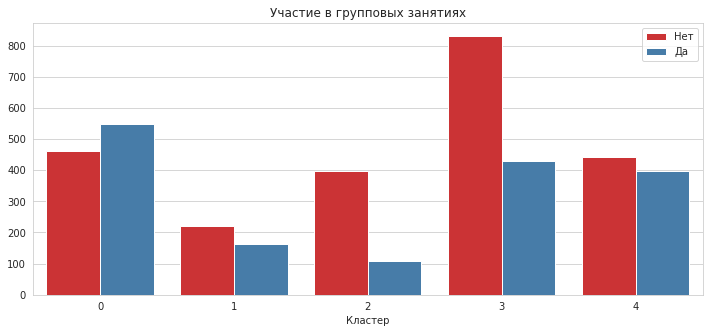

In [34]:
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'cluster_km', hue = 'Group_visits', data = data, palette='Set1')
plt.legend(['Нет','Да'])
plt.title('Участие в групповых занятиях')
plt.ylabel('')
plt.xlabel('Кластер')
plt.show();

В целом, подтверждаются выводы, сделанные в предыдущем пункте с некоторыми уточнениями:
* Главное различие кластеров 0 и 4 в длительности абонементов. В кластере 0 у всех клиентов абонементы на срок более месяца, а у кластера 4 у трети клиентов на три месяца а у остальных на один месяц. Такие образом, кластер 0 - это точно надежные клиенты, а 4 еще не принявшие решение продолжить точно посещать зал длительное время, но демонстрирующие все признаки того, что решение окажется положительным.
* Кластер 1, как и предполагалось это максимально размытые, усредненные и неопределенные клиенты по всем параметрам.
* Кластеры 2 и 3 схожи во всем, с той лишь разницей что во втором кластере живущие далеко клиенты, а в третьем живущие рядом.

<a id="part4-3"></a>
### Доля оттока по кластерам

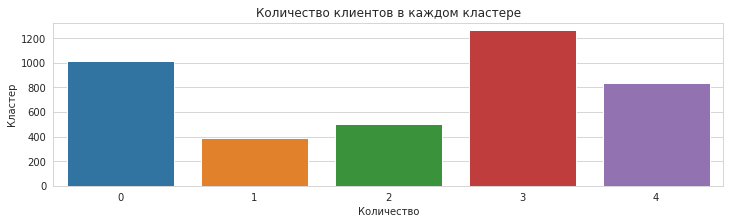

In [35]:
plt.subplots(figsize = (12, 3))
sns.barplot(y='cluster_km', x='index', data=data.cluster_km.value_counts().reset_index())
plt.title('Количество клиентов в каждом кластере')
plt.ylabel('Кластер')
plt.xlabel('Количество')
plt.show();

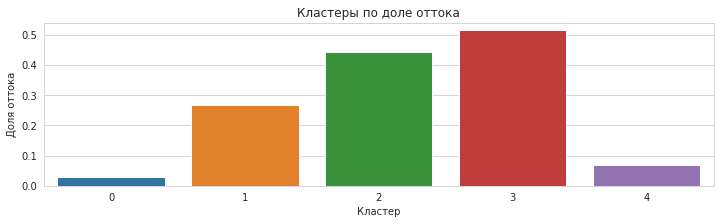

In [36]:
data_cluster_mean =  data.groupby('cluster_km').mean().reset_index()

plt.subplots(figsize = (12, 3))
sns.barplot(y='Churn', x='cluster_km', data=data_cluster_mean)
plt.title('Кластеры по доле оттока')
plt.ylabel('Доля оттока')
plt.xlabel('Кластер')
plt.show();

<a id="part5"></a>
## Выводы и рекомендации

На основе предоставленных данных был проведен анализ и сделанны следующие выводы:

1. Определены признаки, которые оказывают влияние на отток, их влияние на него обратно пропорционально. Вот они в порядке убывания по важности:
 * Время "жизни" клиента (дольше - лучше).
 * Частота посещения клуба в последний месяц (чаще - лучше).
 * Возраст (старше - лучше)
 * Срок действия текущего абонемента (дольше - лучше)
 * Количества месяцев до конца абонемента (больше - лучше)   
   

2. Клиенты поделены на три группы:
 * Группа 1 - Надежные клиенты, имеющие низкую вероятность попасть в отток (менее 7%).
 * Группа 2 - Неопределившиеся клиенты, имеющие среднюю вероятность попасть в отток (около 25%).
 * Группа 3 - Ненадежные клиенты, имеющие высокую вероятность попасть в отток (около 50%).  
   
 
3. Клиенты были поделены на пять кластеров, в которые обученная модель помещала клиентов по уровню склонности к оттоку:
 * Кластеры 0 и 4 - это наиболее активные и вовлеченные клиенты, они давно посещают фитнес-центр и делают это большее количество раз в неделю а абонемент оформляют на долгий срок.
 * Кластер 1 - Это клиенты которые немного склонны к оттоку, их показатели проседают в сравнении с предыдущей. Тем не менее это хоть и малочисленная, но самая важная для нас группа так как этих людей еще можно "завлечь" обратно.
 * Кластер 2 и 3 - Это вероятно те клиенты, кому просто не понравилось заниматься спортом, или не понравился сам фитнес-центр. Они, как правило, только-только впервые пришли и оформили месячный абонемент, но уже почти не ходят заниматься (реже 2-х раз в неделю), редко посещают груповые занятия и не тратятся на доп услуги. Именно по этим метрикам и возможно с высокой точностью предсказывать отток.  
 
Предложения:   

В первую очередь нужно постараться удержать "неопределившихся клиентов", вызвать у них интерес к занятиям.Надежные клиенты ходят два раза в неделю, а те, кто перестал заниматься, ходили реже. Когда человек регулярно занимается у него вырабатывается привычка. Можно дарить новым клиентам бесплатное занятие с тренером или в группе. Можно проводить акции где за каждое, к примеру, 8-е посещение в месяц давать клиенту разовую скидку на доп услуги или иной подарок. А по акции "приведи друга" давать доп скидку если "друг" в первый месяц посетил спорт зал более 5 дней.

Следующий важный аспект - длительность абонемента. Надежные клиенты покупают абонемент на 6 или 12 месяцев. Большое количество уже оплаченных месяцев мотивирует ходить, а это формирует привычку (см. предыдущий пункт). Хорошим решением для улучшения данного показателя будет ценовая политика, когда покупать абонемент на 6 или 12 месяцев гораздо выгоднее чем на один, в перспективе это окупается, так как это влияет на следующий пункт. Еще можно договариваться с компаниями-партнерами на покупку сотрудникам более длительных абонементов. Также можно попробовать ввести трехмесячный абонемент.

Самое важное - постоянные клиенты! Те, кто впервые пришел в зал 5 и более мессяцев назад, кто регулярно посещает фитнес более 2-х раз в неделю. Эти люди почти не склонны к оттоку и высокий показатель "жизни" клиента наиболее их характеризует. Ушедшие в отток, почти сразу перестают пользоваться услушами фитнеса. Поэтому чтоб поднять показатель "времени жизни", важно одновременно собирать фидбек у новичков, узнавать что им НЕ понравилось (это и влияет на тех, кто почти сразу ушел) и в то же время не забывать про ветеранов вашего фитнес-центра - делать им скидки и подарки, ввести карты постоянных клиентов. 

[В начало](#start)